In [2]:
import os
import networkx as nx
import spektral

In [3]:
from spektral.data import Dataset,Graph
from spektral.transforms import LayerPreprocess, Degree, OneHotLabels

In [4]:
import numpy as np
from numpy import append
import pandas
import scipy.io

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [6]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv, GraphMasking,ECCConv, GlobalAvgPool, LaPool, GraphSageConv
from spektral.data import DisjointLoader
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
from spektral.models import GCN
from spektral.layers import GCNConv

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold

In [54]:
import random

In [52]:
from sklearn.metrics import classification_report

In [21]:
from sklearn.metrics import accuracy_score

In [9]:
#Get directorys of each file and put in dictionary

directory = 'TCGACancerStages'
list_of_files = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isdir(f):
        for filenames in os.listdir(f):
            if (filenames[-3:]=='txt'):
                h = os.path.join(f, filenames)
                list_of_files.append(h)

t = 0
dir_dict = {}
for i in range(0,32,4):
    dir_dict[t] = list_of_files[i:i+4]
    t += 1
         

In [10]:
#Check where each graph is in the dictionary
def dict_keys(dir_dict, bool):
    folder_list = []
    for x in range(0,8,1):
        folder_list.clear()
        for y in range(0,4,1):
            split = dir_dict[x][y].split('/')
                
            folder = 'Folder: '+  split[1] + ' = dir_dict['+f'{x}'+']'
        
            if folder not in folder_list:
                folder_list.append(folder)
                print(folder_list[0])
            if (bool == True):
                print('File: '+ split[2], '= dir_dict['+f'{x}'+']['f'{y}'']')
dict_keys(dir_dict, bool = False)

Folder: TCGA-STAD = dir_dict[0]
Folder: TCGA-KIRP = dir_dict[1]
Folder: TCGA-KIRC = dir_dict[2]
Folder: TCGA-LUAD = dir_dict[3]
Folder: TCGA-BRCA = dir_dict[4]
Folder: TCGA-HNSC = dir_dict[5]
Folder: TCGA-THCA = dir_dict[6]
Folder: TCGA-COAD = dir_dict[7]


In [11]:
#Get dictionary with all the graphs
graph_dict = {}

for x in range(8):
    temp_list = []
    for y in range(4):
        G = nx.read_edgelist(f'{dir_dict[x][y]}')
        temp_list.append(G)
    graph_dict[x] = temp_list 

#this dict is still in strings, remeber to turn it into adj matrix and then from scipy sparse matrix to get it into a graph with number

In [12]:
#Create Unique list of the nodes in all 32 graphs
list_o_words = []
for x in range(8):
    for y in range(4):
        with open(f'{dir_dict[x][y]}','r') as f:
            lines = f.readlines()
            for line in lines:
                split = line.split()
                if split[0] not in list_o_words:
                    list_o_words.append(split[0])
                if split[1] not in list_o_words:
                    list_o_words.append(split[1])
                    
            f.close()
            
#Put unique words into a dictionary with an integer value           
word_dict = {}
for i in range(len(list_o_words)):
    word_dict[list_o_words[i]] = i
    
#Onehotenc values in the dictionary Didnt need all of this, easier to manually make onehot
# word_vals = list(word_dict.values())
# word_arr = np.array(word_vals)
# ohe = OneHotEncoder(handle_unknown = 'ignore')
# ohe_words = ohe.fit_transform(word_arr.reshape(-1,1)).toarray()

print(word_dict)

{'CRNN': 0, 'MUC21': 1, 'TMPRSS11B': 2, 'KRT4': 3, 'KPRP': 4, 'IL36A': 5, 'KRT78': 6, 'SBSN': 7, 'SERPINB13': 8, 'TMPRSS11A': 9, 'SLURP1': 10, 'KRT6C': 11, 'CRCT1': 12, 'DYNAP': 13, 'RHCG': 14, 'TGM3': 15, 'IVL': 16, 'CLCA2': 17, 'CAPN14': 18, 'SPRR3': 19, 'CLCA4': 20, 'TMPRSS11D': 21, 'TMPRSS11BNL': 22, 'KRT5': 23, 'SPINK7': 24, 'SPRR2E': 25, 'CAPNS2': 26, 'KRT13': 27, 'TMPRSS11E': 28, 'GBP6': 29, 'HCG22': 30, 'ENDOU': 31, 'A2ML1': 32, 'CERS3': 33, 'FAM25A': 34, 'TGM1': 35, 'CALML3': 36, 'KRTDAP': 37, 'SDR9C7': 38, 'SPRR1A': 39, 'TMPRSS11F': 40, 'RNASE7': 41, 'MAL': 42, 'EPGN': 43, 'CRISP3': 44, 'SERPINB11': 45, 'RNF222': 46, 'FLG': 47, 'KRT1': 48, 'ACER1': 49, 'TFAP2B': 50, 'CNFN': 51, 'CSTA': 52, 'GYS2': 53, 'IRX4': 54, 'SERPINB3': 55, 'SLC39A2': 56, 'DSG1': 57, 'PRSS27': 58, 'LCE3E': 59, 'FAM83C': 60, 'SPRR2A': 61, 'NCCRP1': 62, 'FAT2': 63, 'FOXE1': 64, 'CYP4F29P': 65, 'KLK13': 66, 'BNC1': 67, 'ADH7': 68, 'IL36RN': 69, 'TMEM40': 70, 'ATP12A': 71, 'IGFL1': 72, 'SPINK5': 73, 'SPRR2D'

In [13]:
#Build Dataset
class MyDataset(Dataset):
    """
    A dataset of five random graphs.
    """
    def __init__(self, graph_dict, **kwargs):
        self.graph_dict = graph_dict
        #self.graph = graphs
        #self.label = label
        super().__init__(**kwargs)
    
    
    def read(self):
        output = []
        for y in range(0,8,1):
            for z in range(0,4,1):
                G = graph_dict[y][z]
                a = nx.adjacency_matrix(graph_dict[y][z])
                lisV = list(G.nodes)
                x = np.zeros((len(lisV),len(word_dict)))
                
                
                for i in range(len(lisV)):
                    hotidx = word_dict[lisV[i]]
                    x[i,hotidx] = 1
               
                #want node features to be its unique one-hot encoding 
            
                output.append(
                Graph(x=x,a = a,y = y)
            )
            

        return output

In [131]:
#Load Dataset
dataset = MyDataset(graph_dict)
dataset.apply(OneHotLabels(8,[0,1,2,3,4,5,6,7]))

/var/folders/_0/8qpjvkp91253d9fjqcjqgk200000gn/T/ipykernel_8778/1170129756.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  a = nx.adjacency_matrix(graph_dict[y][z])


In [132]:
random.shuffle(dataset)

In [133]:
learning_rate = 1e-2  # Learning rate
epochs = 40  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 8  # Batch size
optimizer = Adam(learning_rate=learning_rate)
loss_fn = CategoricalCrossentropy()

In [134]:
################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GraphSageConv(32,aggregate = 'max', activation="relu")
        self.conv2 = GraphSageConv(16,aggregate = 'max', activation="relu")
        self.conv3 = GraphSageConv(8, aggregate = 'max', activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(dataset.n_labels, activation="softmax")

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output


model = Net()
optimizer = Adam(learning_rate=learning_rate)
loss_fn = CategoricalCrossentropy()
model.compile(optimizer = optimizer,
         loss = loss_fn,
         metrics = ['acc'],
        run_eagerly=True)

In [135]:
#y labels
y = []
for x in range(32):
    y.append(np.array(np.argmax(dataset[x].y)))
y= np.array(y)
print(y)

[1 6 6 1 6 0 1 4 0 2 3 1 2 5 4 3 4 6 7 5 0 7 5 7 2 0 3 4 3 2 7 5]


In [136]:
#Stratified K fold cross val model
k=4
skf = StratifiedKFold(n_splits=k)
acc_score = []
history = []    
for train_idx,test_idx in skf.split(dataset,y):
#     random.shuffle(train_idx)
#     random.shuffle(test_idx)
    
    X_train,X_test = dataset[train_idx],dataset[test_idx]
    y_train, y_test = y[train_idx],y[test_idx]
    
    loader_tr = DisjointLoader(X_train, batch_size=1, epochs=epochs,shuffle=False)
    loader_te = DisjointLoader(X_test, batch_size=1,shuffle=False)
    
    hist = model.fit(loader_tr.load(),steps_per_epoch=loader_tr.steps_per_epoch,epochs = 6)
    pred_values = model.predict(loader_te.load(),steps=loader_te.steps_per_epoch)
    
    history.append(hist)
    acc = accuracy_score(y_test , np.argmax(pred_values,axis=1))
    print('Test acc: ', acc)
    acc_score.append(acc)

avg_acc_score = sum(acc_score)/k
 
print('Accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

Epoch 1/6
24/24 [==============================] - 21s 890ms/step - loss: 2.1545 - acc: 0.0833
Epoch 2/6
24/24 [==============================] - 19s 839ms/step - loss: 1.9951 - acc: 0.2500
Epoch 3/6
24/24 [==============================] - 19s 835ms/step - loss: 1.8604 - acc: 0.4167
Epoch 4/6
24/24 [==============================] - 21s 893ms/step - loss: 1.7619 - acc: 0.3750
Epoch 5/6
24/24 [==============================] - 16s 686ms/step - loss: 1.5881 - acc: 0.5000
Epoch 6/6
8/8 [==============================] - 7s 524ms/step
Test acc:  0.625
Epoch 1/6
24/24 [==============================] - 15s 539ms/step - loss: 1.3412 - acc: 0.5833
Epoch 2/6
24/24 [==============================] - 17s 606ms/step - loss: 1.2007 - acc: 0.6667
Epoch 3/6
24/24 [==============================] - 21s 768ms/step - loss: 1.0898 - acc: 0.8333
Epoch 4/6
24/24 [==============================] - 18s 631ms/step - loss: 0.9715 - acc: 1.0000
Epoch 5/6
24/24 [==============================] - 18s 613ms/step

In [146]:
model.summary()

Model: "net_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 graph_sage_conv_15 (GraphSa  multiple                 436064    
 geConv)                                                         
                                                                 
 graph_sage_conv_16 (GraphSa  multiple                 1040      
 geConv)                                                         
                                                                 
 graph_sage_conv_17 (GraphSa  multiple                 264       
 geConv)                                                         
                                                                 
 global_avg_pool_5 (GlobalAv  multiple                 0         
 gPool)                                                          
                                                                 
 dense_4 (Dense)             multiple                  72    

In [33]:
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=16,
    callbacks=[EarlyStopping(patience=es_patience, restore_best_weights=True)],
)

Epoch 1/16


/Users/michael.rowe/opt/anaconda3/envs/spektral/lib/python3.9/site-packages/spektral-1.1.0-py3.9.egg/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


16/16 [==============================] - 30s 2s/step - loss: 2.1384 - acc: 0.0625 - val_loss: 2.1070 - val_acc: 0.1250
Epoch 2/16
16/16 [==============================] - 26s 2s/step - loss: 2.0041 - acc: 0.1250 - val_loss: 2.1026 - val_acc: 0.2500
Epoch 3/16
16/16 [==============================] - 27s 2s/step - loss: 1.9104 - acc: 0.3125 - val_loss: 2.0961 - val_acc: 0.2500
Epoch 4/16
16/16 [==============================] - 26s 2s/step - loss: 1.7822 - acc: 0.3125 - val_loss: 2.0452 - val_acc: 0.2500
Epoch 5/16
16/16 [==============================] - 27s 2s/step - loss: 1.6327 - acc: 0.6250 - val_loss: 1.9743 - val_acc: 0.3750
Epoch 6/16
16/16 [==============================] - 26s 2s/step - loss: 1.4613 - acc: 0.5625 - val_loss: 1.9834 - val_acc: 0.1250
Epoch 7/16
16/16 [==============================] - 27s 2s/step - loss: 1.3180 - acc: 0.6875 - val_loss: 2.0449 - val_acc: 0.3750
Epoch 8/16
16/16 [==============================] - 27s 2s/step - loss: 1.2025 - acc: 0.7500 - val_lo

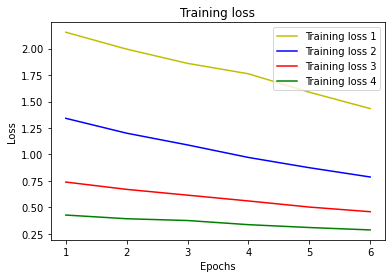

In [143]:
#plot the training and validation accuracy and loss at each epoch
loss1 = history[0].history['loss']
loss2 = history[1].history['loss']
loss3 = history[2].history['loss']
loss4 = history[3].history['loss']
#val_loss = history[0].history['val_loss']
epochs = range(1, 7)
plt.plot(epochs, loss1, 'y', label='Training loss 1')
plt.plot(epochs, loss2, 'b', label='Training loss 2')
plt.plot(epochs, loss3, 'r', label='Training loss 3')
plt.plot(epochs, loss4, 'g', label='Training loss 4')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [142]:
print(epochs)

range(1, 4)


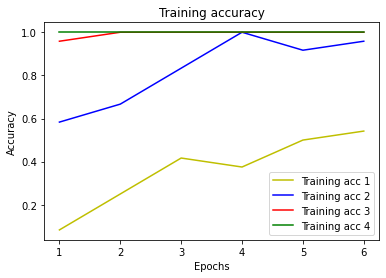

In [145]:
acc1 = history[0].history['acc']
acc2 = history[1].history['acc']
acc3 = history[2].history['acc']
acc4 = history[3].history['acc']
#val_acc = history.history['val_acc']
plt.plot(epochs, acc1, 'y', label='Training acc 1')
plt.plot(epochs, acc2, 'b', label='Training acc 2')
plt.plot(epochs, acc3, 'r', label='Training acc 3')
plt.plot(epochs, acc4, 'g', label='Training acc 4')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()